In [3]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

# 随机生成了一个10臂伯努利老虎机
# 获奖概率最大的拉杆为1号,其获奖概率为0.7203

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [4]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

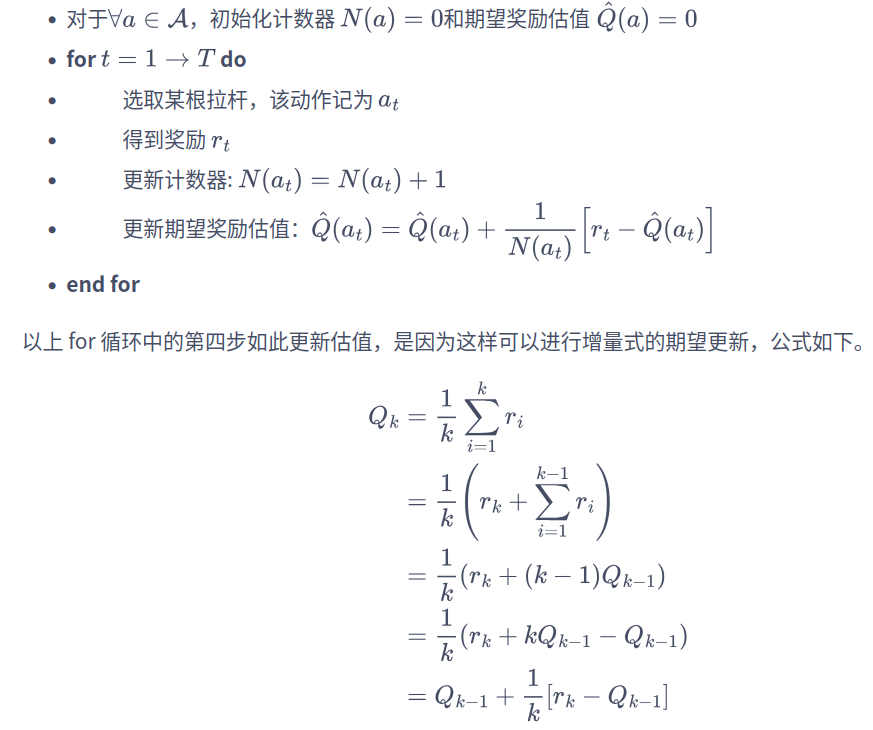

In [ ]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon#表示探索的比率
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:#采样到探索的范围内，进行随机探索，范围是所有action
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:#进行利用，从已知的估计中选择最大的
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励，也是随机的，未必会有奖励
        self.estimates[k] += (r - self.estimates[k])*1. / (self.counts[k] + 1)  #移动平均
        return k

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


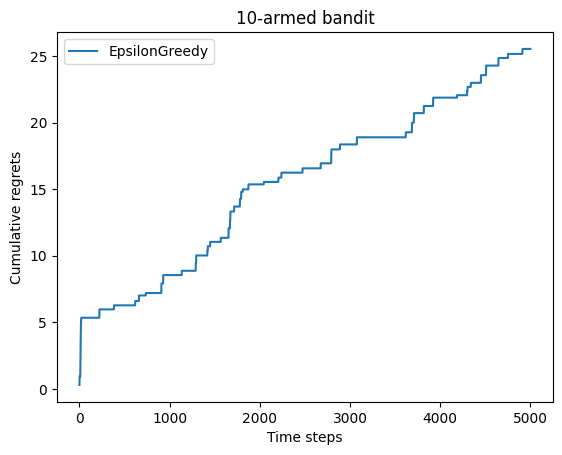

In [6]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

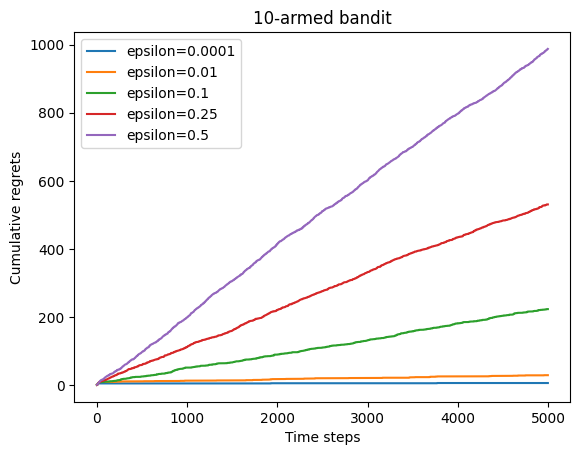

In [7]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


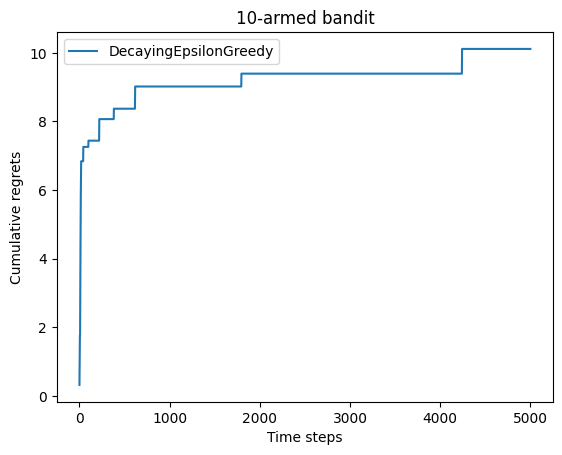

In [ ]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] +=(r -self.estimates[k])*  1. / (self.counts[k] + 1) 

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

# epsilon值衰减的贪婪算法的累积懊悔为：10.114334931260183

上置信界（upper confidence bound，UCB）算法，又称置信区间上界算法。  
他的思想是：显然，当前成功率高的按钮是有高利用价值的，不确定性高的按钮是有高探索价值的。  
我们能不能综合这两种价值，给每种按钮一个评分，从而选择评分最高的按钮呢？

用预估奖励概率（得到奖励的次数 / 按下的次数）$\hat{p}=\frac{n_r}{n}$来衡量某个按钮的“利用价值”就行了，“探索价值”可以用这个按钮的某种不确定性度量来衡量。  
而按钮的评分，最简单的方法就是用两个价值的和来表示。也就是说：  

评分 = 预估奖励概率 + 不确定性度量
$$scores=\frac{n_r}{n}+U$$

如果能够根据我们按按钮的经验找到一个$\delta$，使得$E(X)\leq \hat{p}+\delta$恒成立，  
那么$\hat{p}+\delta$就是真实概率$p=E(X)$的上界，或者说$\hat{p}+\delta$决定了p的取值范围。  
因此在$\hat{p}$确定的情况下， $\delta$越大p的取值范围也就越大。显然$\delta$能够在一定程度上反映按钮的不确定性。

霍夫丁不等式的内容  
设$X_1,X_2,...,X_n$是取值范围为[0, 1]的n个独立同分布随机变量，用$\hat{p}=\frac{1}{n}\sum\limits^{n}_{i=1} X_i$表示它们的样本均值，用p表示它们的分布的均值。那么有  
$$P(p \leq \hat{p}+\delta)\geq 1-e^{-2n\delta^2}$$


想要让$p \leq \hat{p}+\delta$恒成立。可惜这是不现实的，但是好在根据霍夫丁不等式，  
我们可以想办法让$p \leq \hat{p}+\delta$这件事发生的概率足够大，大到我们可以睁一只眼闭一只眼，近似地认为它一定会发生。  
也就是说我们要想办法让霍夫丁不等式右侧$1-e^{-2n\delta^2}$的在小于1的限制下（不清楚的话可以分析一下它的值域）足够大  

选择$\frac{N-1}{N}$,令$1-e^{-2n\delta^2}=\frac{N-1}{N}$解这个方程可以得到$\delta=\sqrt{\frac{ln (N)}{2n}}$  
其中n代表某一个action被选中的次数，N表示选择所有action的总计次数，即时间步，  
可以发现随着时间步增加，$1-e^{-2n\delta^2}=\frac{N-1}{N}$越来越大  

结论就是我们令$\delta=\sqrt{\frac{ln (N)}{2n}}$，可以几乎使得$p \leq \hat{p}+\delta$恒成立，因此$\delta$是一个不错的不确定性度量  

当n不变时，$\delta$随着N的增大而增大。也就是说，当我们始终不按某个按钮，却多次按下其它按钮时，这个按钮的不确定性（相对别的按钮而言）就升高了  
当N不变时，$\delta$随着n的增大而减小。也就是说，当我们按某个按钮的比例增大后，这个按钮的不确定性（相对别的按钮而言）就降低了  

$$scores=\frac{n_r}{n}+\sqrt{\frac{ln (N)}{2n}}$$
每次选择评分scores最高的按钮，为了防止分母爆零，我们可以将分母加上1。  
另外，为了调节探索与利用的权重，我们可以在根号前乘上一个超参数c，以便通过设置一个较大的c使策略更加注重探索。
相当于在工程上会使用这个评分表达式：
$$scores=\frac{n_r}{n}+C\sqrt{\frac{ln (N)}{2n+1}}$$

上置信界算法的累积懊悔为： 89.4086503322641


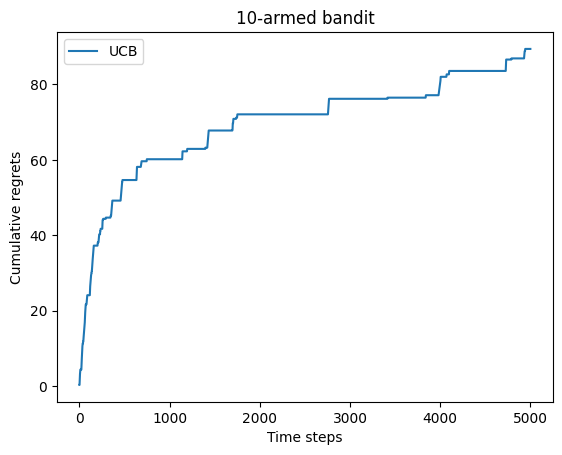

In [11]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * self.counts + 1))  # 计算所有action的上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r -self.estimates[k])
        return k


np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

# 上置信界算法的累积懊悔为： 70.45281214197854

汤普森采样(TS: Thompson sampling)  
一个Thompson sampling算法的基本思想和UCB算法类似，我们基于先前收集的信息(动作及其反馈)构造一个所有动作(或arm)reward分布的信念(belief)集合或者我们称之为信念状态(belief state in MDP domain), 在每次决策中选择后验信念或后验概率(posterior probability)最优的动作。  

在这里，信念或后验概率的概念源自贝叶斯统计，这使得我们需要简单回顾一下贝叶斯方法。  
Bernoulli后验与Beta分布  

我们回顾基本的贝叶斯方法，贝叶斯推理与frequentist inference核心区别在于, 在贝叶斯推理(bayesian inference):  
1.我们把模型的参数变量$\theta$看成是随机的，把要进行模型拟合的数据D当成是确定的。  
2.同时，我们假定模型的参数$\theta$服从一个先验分布$f(\theta)$。  
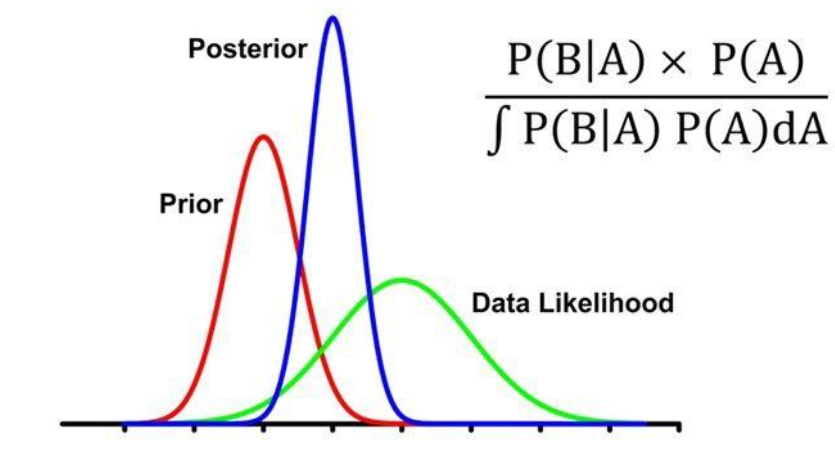  

以Bernoulli分布为例，若一枚硬币服从参数为$\theta$(正面朝上的概率)的i.i.d的伯努利分布(Bernoulli distribution), 我们有，  
$$
p(x) = \begin{cases} 1 & \text{with} \ prob=\theta \\ 0 & \text{with} \ prob=1-\theta  \end{cases}
$$
贝叶斯公式:  
$$p(\theta|D)=\frac{p(D|\theta)p(\theta)}{p(D)}=\frac{p(D|\theta)p(\theta)}{\int p(D|\theta)p(\theta) d\theta}$$
其中，  
1.$p(\theta)$:参数的先验(prior)。  
2.$p(D|\theta)$:似然函数(likelihood)  
3.$p(\theta|D)$后验分布(posterior distribution).  

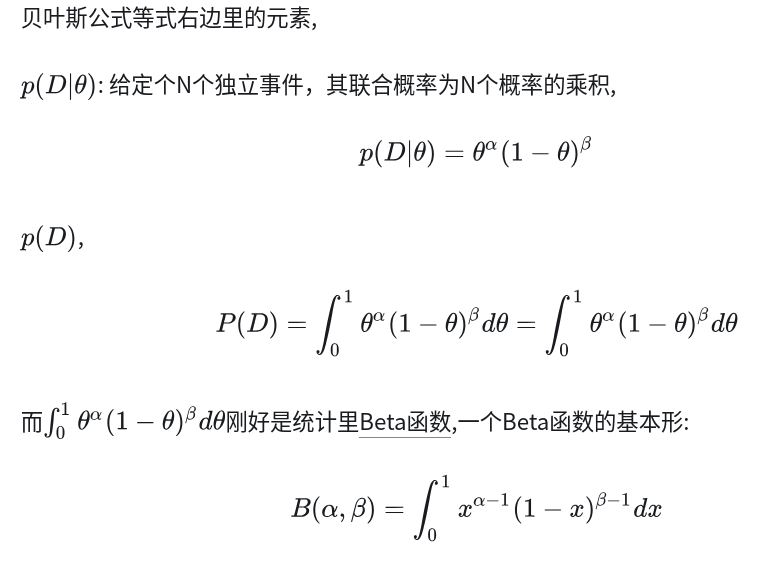   
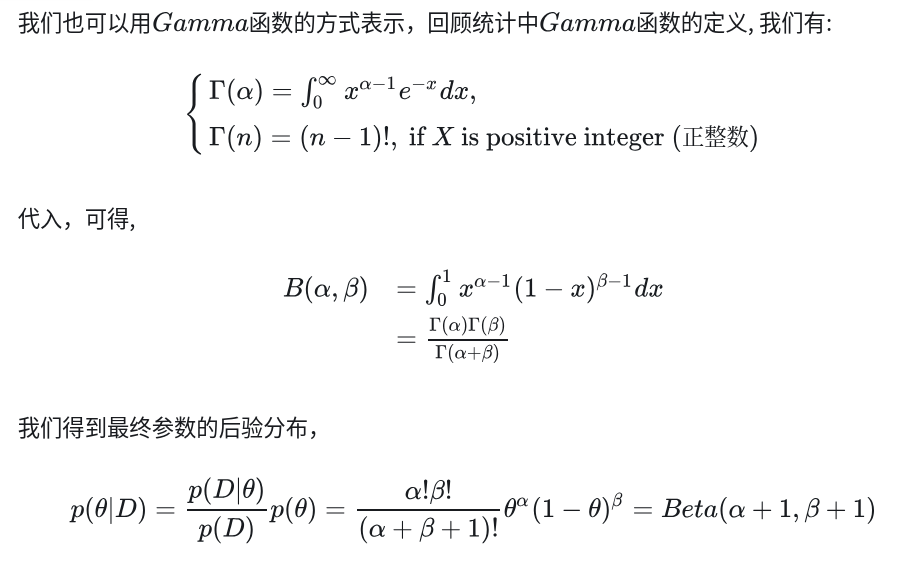  
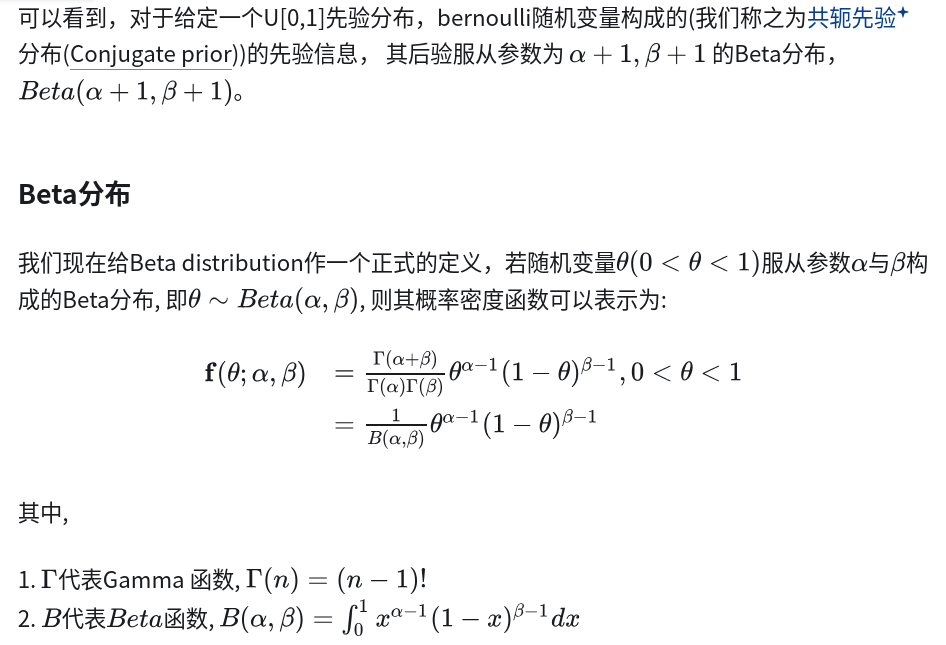  
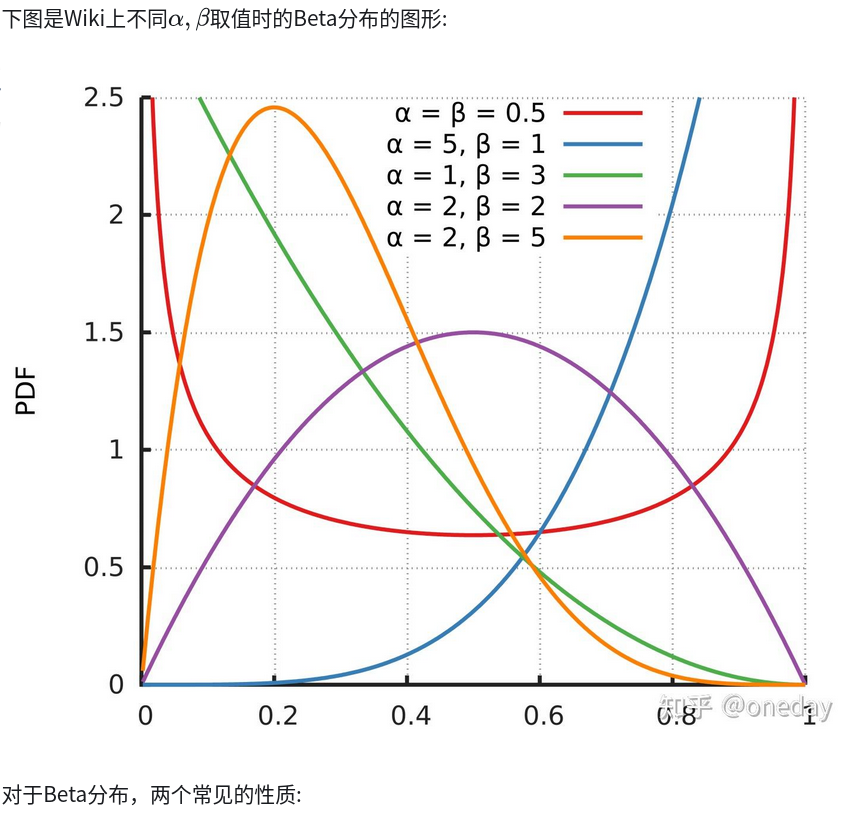  


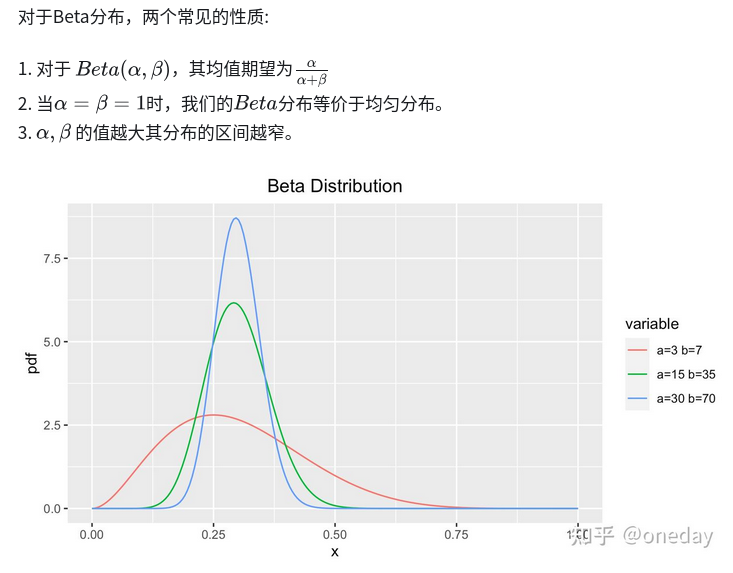  
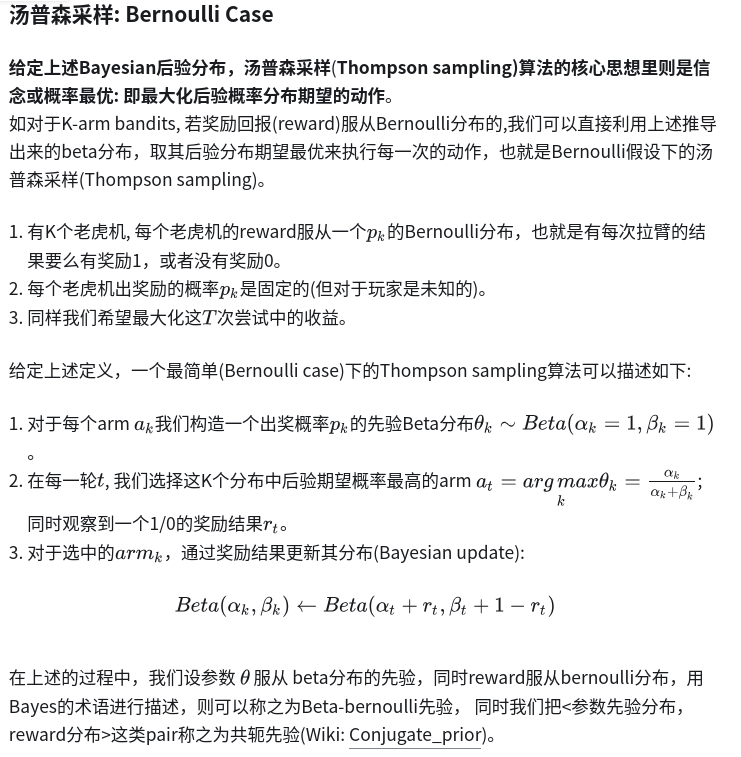

$$p(\theta|D)=\frac{p(D|\theta)p(\theta)}{p(D)}=\frac{p(D|\theta)p(\theta)}{\int p(D|\theta)p(\theta) d\theta}=Beta(\alpha+1,\beta+1)$$
简而言之，我们不知道每个老虎机奖励的概率分布函数(0-1分布)参数$\theta$，  
我通过事先假定$\theta$服从均匀分布($Beta(1,1)$),然后在此条件下进行采样得到数据来估计参数$\theta$   
$\alpha$代表采样得到奖励的总次数，$\beta$代表采样未得到奖励的总次数  
由于每次只有一个采样，因此是每次采样后都更新Beta的参数 


汤普森采样算法的累积懊悔为： 57.19161964443925


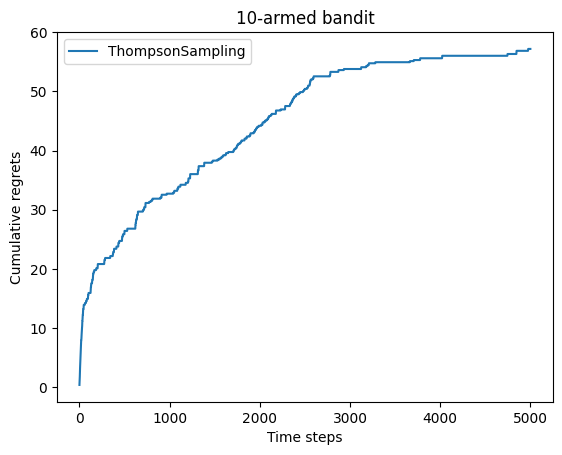

In [ ]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本，其实是采样了一组参数，该参数就代表得到奖励的概率
        k = np.argmax(samples)  # 选出采样奖励概率最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

# 汤普森采样算法的累积懊悔为：57.19161964443925